#### Abrindo os dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import seaborn as sns
from scipy.stats import wilcoxon
#%matplotlib inline
plt.style.use('ggplot')

In [2]:
graficos_dir = r'D:\Trabalho\faculdade\TCC\outputs\graficos\analise_exploratoria'

In [3]:
data = pd.read_csv(r'D:\Trabalho\faculdade\TCC\outputs\tabelas\dados_treino_offset.csv')
data['data_medicao'] = pd.to_datetime(data['data_medicao'])
data['lentidao'] = data['lentidao']/1000 #Transformando em km

#### Plotando lentidão ao longo do dia

In [4]:
lentidao_por_horario = data.groupby(data.data_medicao.dt.hour).agg('sum')
fig,ax = plt.subplots(figsize=(16,6))
ax.bar(x=lentidao_por_horario.index,height=lentidao_por_horario['lentidao'], color='deepskyblue')
ax.set_xticks(lentidao_por_horario.index)
ax.set_xticklabels(labels= lentidao_por_horario.index)
ax.set_ylabel('Slowness', fontsize=14)
plt.savefig(r'D:\Trabalho\faculdade\TCC\outputs\graficos\analise_exploratoria\slowness_by_time_of_day.png')
plt.show()

In [5]:
xs = pd.to_datetime(lentidao_por_horario.reset_index()['data_medicao'], format='%H')
xs = xs - datetime.datetime.strptime('00:00:00', '%H:%M:%S')
xs = xs.dt.seconds / (24 * 3600)
xs = xs * 2 * np.pi

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, projection = 'polar')
ax.bar(xs, lentidao_por_horario['lentidao'], width = 0.1, alpha=0.3, color='deepskyblue')

# Make the labels go clockwise
ax.set_theta_direction(-1)

#Place Zero at Top
ax.set_theta_offset(np.pi/2)

#Set the circumference ticks
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))

# set the label names
ticks = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM','8 AM','9 AM','10 AM','11 AM','12 PM', '1 PM', '2 PM', '3 PM', '4 PM',  '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM' ]
ax.set_xticklabels(ticks)

# suppress the radial labels
plt.setp(ax.get_yticklabels(), visible=False)

#Bars to the wall
plt.ylim(0,lentidao_por_horario['lentidao'].max())

#plt.legend(bbox_to_anchor=(1,0), fancybox=True, shadow=True)
plt.savefig(os.path.join(graficos_dir,'lentidao_por_horario_clockplot.png'))
plt.show()


#### Plotando lentidão ao longo do ano

In [6]:
lentidao_meia_hora = data.groupby('data_medicao').agg('sum').reset_index()
lentidao_por_mes = lentidao_meia_hora.groupby(lentidao_meia_hora.data_medicao.dt.month).agg('mean')
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(lentidao_por_mes.index,lentidao_por_mes['lentidao'], c='deepskyblue')
ax.set_xticks(lentidao_por_mes.index)
ax.set_xticklabels(labels= lentidao_por_mes.index)
ax.set_ylabel('Slowness', fontsize=14)
plt.show()

#### Verificando a lentidão média

In [7]:
lentidao_meia_hora = data.groupby('data_medicao').agg('sum').reset_index()
lentidao_media = lentidao_meia_hora['lentidao'].mean()
print(f' A lentidão diária média é de {round(lentidao_media,2)} Km de extensão')

 A lentidão diária média é de 36.17 Km de extensão


#### Verificando  quais são os trechos de maior lentidão média anual

In [8]:
lentidao_meia_hora_por_corredor = data.groupby(['data_medicao','corredor']).agg('sum').reset_index()
lentidao_media_por_corredor = lentidao_meia_hora_por_corredor.groupby('corredor').agg('mean').sort_values('lentidao',ascending=False)[['lentidao']]
lentidao_media_por_corredor.head(5)

,lentidao
corredor,
Marginal Tietê,12.304876
Marginal Pinheiros,10.064325
Marginal Tietê - Pista Central,5.369398
Vinte Três/R Berta/M Guimarães,3.941529
"Bandeirantes, Av dos",2.658439


#### Distribuição da lentidão

In [ ]:
fig,ax = plt.subplots(figsize=(16,6))
ax.hist(data['lentidao'], bins=50, density=False, color='deepskyblue', density=True)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Slowness',fontsize=14)
plt.show()

In [10]:
sns.set(rc={'figure.figsize':(10,6)})

histograma = sns.distplot(data['lentidao'], hist=True, kde=True, 
             bins=int(100), color = 'skyblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'color':'red'})

fig = histograma.get_figure()
sns.set(font_scale=1)
histograma.set(xlabel ="Slowness (Km)", ylabel = "Density", title ='')
fig.savefig(os.path.join(graficos_dir, "histograma_lentidao.png")) 
fig.show()

[10]:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



#### Fazendo testes de hipótese

##### Alagamento

H0 --> A lentidao durante alagamentos é igual a quando não há alagamentos

H1 --> A lentidão durante alagamentos é maior do que quando não há alagamentos

In [6]:
#lentidao media por rua e horario em dias sem alagamento
sem_alagamentos = data[data['quantidade_alagamentos']==0].groupby([data['data_medicao'].dt.hour,'corredor']).agg('mean')['lentidao']
#lentidao media por rua e horario em dias com mais de 2 alagamentos
com_alagamentos = data[data['quantidade_alagamentos']>=1].groupby([data['data_medicao'].dt.hour,'corredor']).agg('mean')['lentidao']
#Comparando lentidao em dias com e sem alagamento
comparacao_alagamentos = pd.merge(com_alagamentos, sem_alagamentos, left_index = True, right_index = True).rename(columns={'lentidao_x':'lentidao_com_alagamento','lentidao_y':'lentidao_sem_alagamento'})
stat, p = wilcoxon(comparacao_alagamentos['lentidao_com_alagamento'],comparacao_alagamentos['lentidao_sem_alagamento'], alternative='greater')
print(f'p-value:{p}')

p-value:5.130751382048811e-19


In [43]:
d = comparacao_alagamentos.groupby(level=0).agg('sum')
lent_total_com_alag = comparacao_alagamentos['lentidao_com_alagamento'].sum()
lent_total_sem_alag = comparacao_alagamentos['lentidao_sem_alagamento'].sum()
perc_diff = (lent_total_sem_alag-lent_total_com_alag)/lent_total_sem_alag

print(f'Em dias de alagamento a lentidão é {round(abs(perc_diff)*100,2)}% maior')

Em dias de alagamento a lentidão é 39.05% maior


###### Visualização

In [6]:
d = comparacao_alagamentos.groupby(level=0).agg('sum')
X = d.index
lent_com_alag = d['lentidao_com_alagamento']
lent_sem_alag = d['lentidao_sem_alagamento']
X_axis = np.arange(len(X))
fig,ax = plt.subplots(figsize = (10,6))
#ax.bar(X_axis - 0.2, lent_sem_alag, 0.4, label = 'No floods', color='gold')
#ax.bar(X_axis + 0.2, lent_com_alag, 0.4, label = 'With floods', color='skyblue')
ax.plot(X_axis, lent_sem_alag, c='r')
ax.plot(X_axis, lent_com_alag, c='b')

plt.xticks(X_axis, X)
plt.xlabel("Time of day")
plt.ylabel("Slowness (km)")
#plt.title("Number of Students in each group")
plt.legend()
fig.savefig(os.path.join(graficos_dir, "comparacao_com_e_sem_alag.png")) 
plt.show()

NameError: name 'comparacao_alagamentos' is not defined

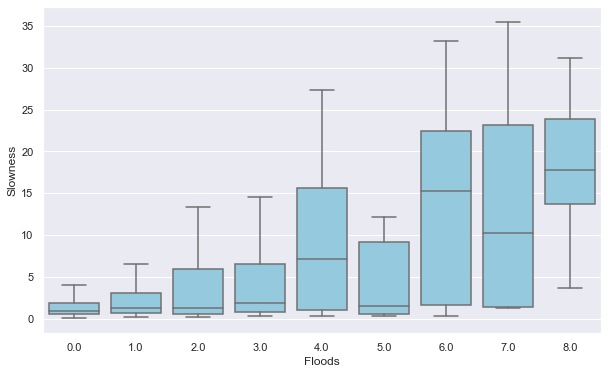

In [36]:
plot = seaborn.boxplot(data=data, x='quantidade_alagamentos', y='lentidao', showfliers=False,color='skyblue')
plot.set(xlabel ="Floods", ylabel = "Slowness", title ='')
fig = plot.get_figure()
fig.savefig(os.path.join(graficos_dir, "boxplot_alagamentos.png")) 
plt.show()

##### Chuva

H0 --> A lentidao durante chuva é igual a quando não há alagamentos

H1 --> A lentidão durante chuva é maior do que quando não há alagamentos

In [350]:
#lentidao media por rua e horario em dias sem chuva
sem_chuva = data[data['precipitacao']==0].groupby([data['data_medicao'].dt.hour,'corredor']).agg('mean')['lentidao']
#lentidao media por rua e horario em dias com mais de 2 alagamentos
com_chuva = data[data['precipitacao']>=1].groupby([data['data_medicao'].dt.hour,'corredor']).agg('mean')['lentidao']
#Comparando lentidao em dias com e sem alagamento
comparacao_chuva = pd.merge(com_chuva, sem_chuva, left_index = True, right_index = True).rename(columns={'lentidao_x':'lentidao_com_chuva','lentidao_y':'lentidao_sem_chuva'})
stat, p = wilcoxon(comparacao_chuva['lentidao_com_chuva'],comparacao_chuva['lentidao_sem_chuva'], alternative='greater')
print(f'p-value:{p}')

p-value:1.1310857968416641e-23


In [352]:
d = comparacao_chuva.groupby(level=0).agg('sum')
lent_total_com_chuva = comparacao_chuva['lentidao_com_chuva'].sum()
lent_total_sem_chuva = comparacao_chuva['lentidao_sem_chuva'].sum()
perc_diff = (lent_total_sem_chuva-lent_total_com_chuva)/lent_total_sem_chuva

print(f'Em dias de chuva a lentidão é {round(abs(perc_diff)*100,2)}% maior')

Em dias de chuva a lentidão é 14.37% maior


###### Visualização

In [4]:
def classify_rain(rain):
    if rain==0:
        return 'no rain'
    elif rain < 10:
        return 'rain'
    elif rain<30:
        return 'moderate'
    else:
        return 'severe'
   

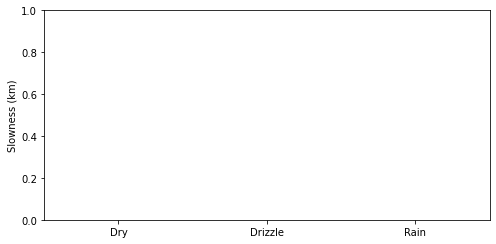

In [10]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

chuva_vis = data.copy()[['precipitacao','lentidao']]
chuva_vis['precipitacao_classe'] = chuva_vis['precipitacao'].apply(lambda x: classify_rain(x))
plot = sns.boxplot(data=chuva_vis, x='precipitacao_classe', y='lentidao',
                       showfliers=False,color='skyblue',
                      order = ['Dry','Drizzle', 'Rain'])
plot.set (xlabel='',ylabel = "Slowness (km)", title ='')
#plot.set_xticklabels(['no rain','weak','moderate','severe','very severe'])
plt.show()
#fig = plot.get_figure()
#fig.savefig(os.path.join(graficos_dir, "boxplot_chuva.png")) 
#plt.show()

In [203]:
lent_total_sem_chuva

1525.7064941679644

In [353]:
lent_total_com_chuva

1744.9069620314758

In [388]:
data['precipitacao'].quantile(0.99)

3.0

##### Acidentes

H0 --> A lentidao durante acidentes é igual a quando não há alagamentos

H1 --> A lentidão durante acidentes é maior do que quando não há alagamentos

In [294]:
#lentidao media por rua e horario em dias sem alagamento
sem_acidente = data[data['quantidade_acidentes']==0].groupby([data['data_medicao'].dt.hour,'corredor']).agg('mean')['lentidao']
#lentidao media por rua e horario em dias com mais de 2 alagamentos
com_acidente = data[data['quantidade_acidentes']>=2].groupby([data['data_medicao'].dt.hour,'corredor']).agg('mean')['lentidao']
#Comparando lentidao em dias com e sem alagamento
comparacao_acidentes = pd.merge(com_acidente, sem_acidente, left_index = True, right_index = True).rename(columns={'lentidao_x':'lentidao_com_acidente','lentidao_y':'lentidao_sem_acidente'})
stat, p = wilcoxon(comparacao_acidentes['lentidao_com_acidente'],comparacao_acidentes['lentidao_sem_acidente'], alternative='greater')
print(f'p-value:{p}')

p-value:0.0997616052045911


###### Visualização 

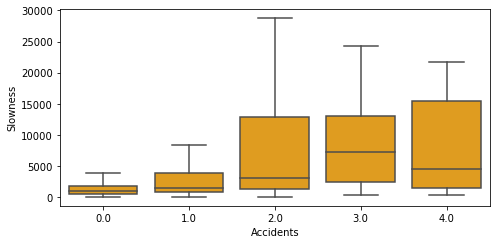

In [26]:
plot = seaborn.boxplot(data=data[data['quantidade_acidentes']<5], x='quantidade_acidentes', y='lentidao', showfliers=False,color='orange')
plot.set(xlabel ="Accidents", ylabel = "Slowness", title ='')
fig = plot.get_figure()
fig.savefig(os.path.join(graficos_dir, "boxplot_acidentes.png")) 
plt.show()

#### Socioeconomico

In [144]:
len(comparacao_alagamentos['lentidao_com_alagamento'])

484

In [145]:
comparacao_alagamentos.groupby(level=0).agg('sum').reset_index()

,data_medicao,lentidao_com_alagamento,lentidao_sem_alagamento
0,0,20.517000,7.722311
1,4,4.210000,2.662026
2,5,19.145000,5.793391
3,6,28.824792,12.864825
4,7,74.082319,42.932841
5,8,104.539207,69.157209
6,9,104.737610,76.402932
7,10,89.275154,66.342023
8,11,74.986386,59.714605
9,12,45.377833,35.715756


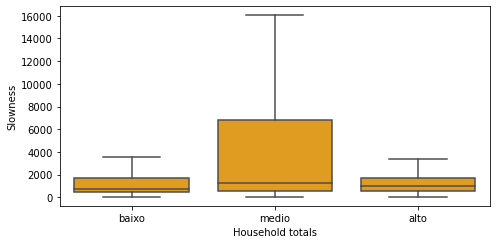

In [27]:
vis_socioeconomico = data.copy()[['lentidao','population_density','household_totals','average_household_size','primary_education','secondary_education','superior_education','purchasing_power']]
vis_socioeconomico['populacao_classifica'] = vis_socioeconomico['household_totals'].apply(lambda x: 'baixo' if x<7000 else 'alto')

vis_socioeconomico['classifica_densidade'] = pd.cut(vis_socioeconomico['population_density'],[0,4000,7000,np.inf], include_lowest=False, right=False, labels=['baixo','medio','alto'])
vis_socioeconomico['classifica_household_totals'] = pd.cut(vis_socioeconomico['household_totals'],[0,4000,7000,10000,np.inf], include_lowest=False, right=False, labels=['low','medium','high','very high'])
vis_socioeconomico['classifica_purchasing_power'] = pd.cut(vis_socioeconomico['purchasing_power'],[0,40000,80000,130000,np.inf], include_lowest=False, right=False, labels=['low','medium','high','very high'])
#vis_socioeconomico['classifica_superior_education'] = pd.cut(vis_socioeconomico['purchasing_power'],[0,1000,3000,8000,np.inf], include_lowest=False, right=False, labels=['low','medium','high','very high'])


plot = seaborn.boxplot(data=vis_socioeconomico, x='classifica_densidade', y='lentidao', showfliers=False,color='orange')
plot.set(xlabel ="Household totals", ylabel = "Slowness", title ='')
fig = plot.get_figure()
fig.savefig(os.path.join(graficos_dir, "boxplot_household_totals.png")) 
plt.show()

In [28]:
#em media, a lentidao é de quanto % do tamanho da rua
#data['lentidao_porcentagem'] = data['lentidao']/data['tamanho_corredor']